In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [2]:
D1_LINEAR_GAUSIAN_250px = "D://250px_LI_GB_D1/"
D1_LINEAR_GAUSIAN_227px = "D://227px_LI_GB_D1/"
D2_LINEAR_GAUSIAN_227px = "D://227px_LI_GB_D2/"
D2_LINEAR_GAUSIAN_250px = "D://250px_LI_GB_D2/"
D1_AREA_GAUSIAN_227px = "D://227px_AI_GB_D1/"
D1_AREA_GAUSIAN_250px = "D://250px_AI_GB_D1/"

D1_D2_MIXED_250px = "D://D1_D2_MIXED_250px/"
ds_type = D1_AREA_GAUSIAN_227px
dataset_path = signature_types = os.listdir(ds_type)
signs = []
for item in signature_types:
  all_signs = os.listdir(ds_type+"/"+item)
  for sign in all_signs:
    if sign.endswith(".db"):
      pass
    else: 
      signs.append((item, str(ds_type+"/"+item) + "/" + sign))
signs_df = pd.DataFrame(data = signs, columns = ["sign type", "image"])
sign_count = signs_df["sign type"].value_counts()
print("Signatures in each category:")
print(sign_count)

Signatures in each category:
forgeries    1320
genuine      1320
Name: sign type, dtype: int64


In [3]:
images = []
labels = []
for i in signature_types:
  data_path = ds_type + str(i)
  filenames = [i for i in os.listdir(data_path)]
  for f in tqdm(filenames, desc=f"Processing {i}"):
    if f.endswith(".db"):
      pass
    else:
      img = cv2.imread(data_path + "/" + f)
      images.append(img)
      labels.append(i)

Processing genuine: 100%|██████████| 1320/1320 [00:01<00:00, 1249.71it/s]


In [4]:
images = np.array(images)
images = images.astype('float32') / 255.0

In [5]:
y = signs_df['sign type'].values
y = y.reshape(-1,1)
columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), [0])], remainder='passthrough')
Y=np.array(columnTransformer.fit_transform(y),dtype='float32')
print(Y.shape)

(2640, 2)


In [6]:
images, Y = shuffle(images,Y,random_state=42)
train_x,test_x,train_y,test_y = train_test_split(images, Y, test_size=0.2, random_state=42)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(2112, 227, 227, 3)
(528, 227, 227, 3)
(2112, 2)
(528, 2)


In [7]:
train_x = train_x / 255.0
test_x = test_x / 255.0

In [8]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout
from tensorflow.keras.models import Model

In [9]:
image_size=[227,227]
model = ResNet101(input_shape=image_size+[3],include_top = False, weights = 'imagenet')

In [10]:
# model.summary()

In [11]:
for layers in model.layers:
  layers.trainable = False

In [12]:
arc = Model(inputs=model.input,outputs=Dense(2,activation='softmax')(Flatten()(model.output)))
# arc.summary()

In [13]:
# from tensorflow.keras.optimizers import RMSprop
# arc.compile(loss='categorical_crossentropy',optimizer=RMSprop(learning_rate=0.001),metrics=['accuracy'])
# opti = tf.keras.optimizers.SGD(learning_rate=0.001,)
# arc.compile(optimizer=opti,loss='BinaryCrossentropy',metrics=['accuracy'])
arc.compile(optimizer='adam',loss='BinaryCrossentropy',metrics=['accuracy'])

In [14]:
history = arc.fit(train_x, train_y, validation_data=(test_x,test_y), epochs = 30)

Epoch 1/30
66/66 [==============================] - 18s 193ms/step - loss: 2.1376 - accuracy: 0.4882 - val_loss: 1.1690 - val_accuracy: 0.4792
Epoch 2/30
66/66 [==============================] - 11s 164ms/step - loss: 0.9182 - accuracy: 0.5090 - val_loss: 0.8970 - val_accuracy: 0.5208
Epoch 3/30
66/66 [==============================] - 11s 164ms/step - loss: 1.0098 - accuracy: 0.5043 - val_loss: 0.8601 - val_accuracy: 0.4792
Epoch 4/30
66/66 [==============================] - 11s 164ms/step - loss: 0.8591 - accuracy: 0.5071 - val_loss: 1.0413 - val_accuracy: 0.4792
Epoch 5/30
66/66 [==============================] - 11s 165ms/step - loss: 0.9554 - accuracy: 0.4910 - val_loss: 1.7197 - val_accuracy: 0.5208
Epoch 6/30
66/66 [==============================] - 11s 164ms/step - loss: 1.2174 - accuracy: 0.5014 - val_loss: 0.9861 - val_accuracy: 0.4792
Epoch 7/30
66/66 [==============================] - 11s 164ms/step - loss: 0.9217 - accuracy: 0.4844 - val_loss: 0.8070 - val_accuracy: 0.5208

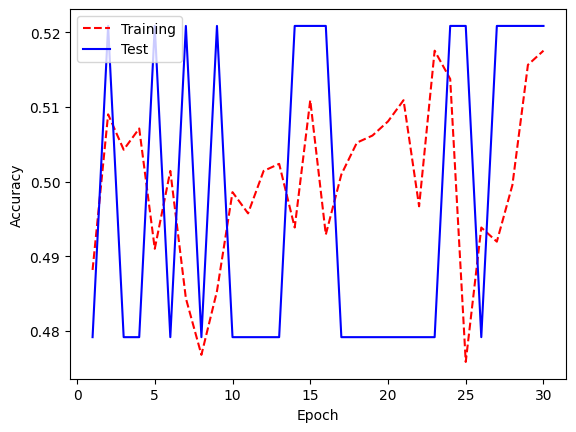

In [15]:
training_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
epoch_count = range(1, len(training_acc) + 1)
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [16]:
testing = arc.evaluate(test_x, test_y)
predictions = arc.predict(test_x)
pred_y = np.argmax(predictions, axis = 1)
test_y = np.argmax(test_y, axis=1)
print(classification_report(test_y,pred_y))

17/17 [==============================] - 3s 128ms/step
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       275
           1       0.00      0.00      0.00       253

    accuracy                           0.52       528
   macro avg       0.26      0.50      0.34       528
weighted avg       0.27      0.52      0.36       528



C:\Users\einzeL\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\einzeL\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\einzeL\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [17]:
cm = confusion_matrix(test_y, pred_y)
print(cm)

[[275   0]
 [253   0]]
